In [1]:
# M2 Q1 – Spatial Movement Styles
# Erica

# Research Question:
# Do pet cats exhibit distinct spatial movement styles at the individual level, independent of time?

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [3]:
# pulls dataset
url1 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk.csv"

cats_uk = pd.read_csv(url1)

url2 = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2023/2023-01-31/cats_uk_reference.csv"

cats_uk_ref = pd.read_csv(url2)

In [4]:
cats_uk.head()

,tag_id,event_id,visible,timestamp,location_long,location_lat,ground_speed,height_above_ellipsoid,algorithm_marked_outlier,manually_marked_outlier,study_name
0,Ares,3395610551,True,2017-06-24T01:03:57Z,-5.113851,50.170315,684,154.67,False,False,Pet Cats United Kingdom
1,Ares,3395610552,True,2017-06-24T01:11:20Z,-5.113851,50.170315,936,154.67,False,False,Pet Cats United Kingdom
2,Ares,3395610553,True,2017-06-24T02:58:16Z,-5.113730,50.169876,2340,81.35,False,False,Pet Cats United Kingdom
3,Ares,3395610554,True,2017-06-24T03:01:26Z,-5.113774,50.169827,0,67.82,False,False,Pet Cats United Kingdom
4,Ares,3395610555,True,2017-06-24T03:51:58Z,-5.114247,50.170139,4896,118.03,False,False,Pet Cats United Kingdom


In [6]:
cats_uk_ref.head()

,tag_id,animal_id,animal_taxon,deploy_on_date,deploy_off_date,hunt,prey_p_month,animal_reproductive_condition,animal_sex,hrs_indoors,n_cats,food_dry,food_wet,food_other,study_site,age_years
0,Tommy-Tag,Tommy,Felis catus,2017-06-03T01:02:09Z,2017-06-10T02:10:52Z,True,12.5,Neutered,m,12.5,2,True,True,False,UK,11.0
1,Athena,Athena,Felis catus,2017-06-24T01:02:13Z,2017-06-30T23:59:32Z,True,3.0,Spayed,f,7.5,2,True,True,False,UK,3.0
2,Ares,Ares,Felis catus,2017-06-24T01:03:57Z,2017-06-30T23:58:01Z,NaN,0.0,Neutered,m,7.5,2,True,True,False,UK,3.0
3,Lola,Lola,Felis catus,2017-06-24T01:18:49Z,2017-06-30T09:04:40Z,True,3.0,Spayed,f,17.5,1,True,True,False,UK,10.0
4,Maverick,Maverick,Felis catus,2017-06-25T01:04:35Z,2017-07-03T09:10:07Z,True,3.0,Neutered,m,12.5,1,True,True,True,UK,7.0


In [7]:
cats_uk_clean = cats_uk.dropna(subset=["timestamp", "location_lat", "location_long"]).copy()

# **EDA from M1**

Question: Do cats exhibit distinct styles of spatial movement, such as highly localized routines versus exploratory roaming, and how sharply separated are these behaviors across individuals?

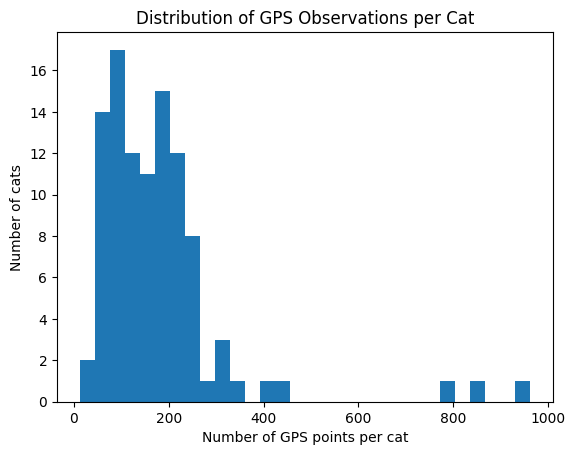

In [8]:
points_per_cat = cats_uk.groupby("tag_id").size()

plt.figure()
plt.hist(points_per_cat, bins=30)
plt.xlabel("Number of GPS points per cat")
plt.ylabel("Number of cats")
plt.title("Distribution of GPS Observations per Cat")
plt.show()

Insight: The dataset is not a uniform sample of movement behavior but a collection of uneven individual movement histories. There are three cats who are outliers with many more GPS points (>800)

Question: Among cats with similar indoor constraints, are movement behaviors similar, or do they demonstrate similar spatial usage patterns?

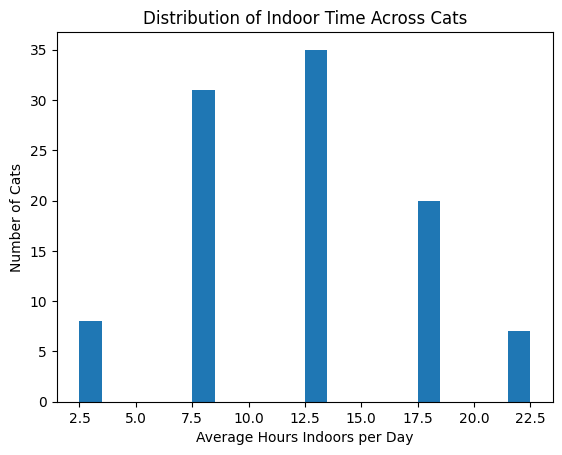

In [9]:
plt.figure()
plt.hist(cats_uk_ref["hrs_indoors"].dropna(), bins=20)
plt.xlabel("Average Hours Indoors per Day")
plt.ylabel("Number of Cats")
plt.title("Distribution of Indoor Time Across Cats")
plt.show()

Insight: Cats subject to similar constraints exhibit diverse spatial usage patterns and movement styles, suggesting that simple household rules do not fully determine behavioral outcomes

In [11]:
valid_cats = points_per_cat[points_per_cat >= 50].index
cats_q1 = cats_uk_clean[cats_uk_clean["tag_id"].isin(valid_cats)].copy()

**Cats with very few GPS observations were excluded because spatial summaries become unstable under sparse sampling.**

Although timestamps are available in the raw data, Question 1 deliberately excludes temporal information in order to focus on aggregate, individual-level spatial movement styles rather than time-ordered trajectories.


#Section 1. Introduction & Question

This analysis investigates whether pet cats exhibit distinct spatial movement styles at the individual level.
Rather than focusing on time-ordered trajectories or temporal routines, this question deliberately examines
aggregate spatial behavior, asking whether cats differ meaningfully in how broadly or narrowly they use space.


Temporal information is intentionally excluded in this question in order to isolate spatial movement style
from temporal sequencing effects, which are explored in subsequent analyses.

#Section 2. Data Overview

In [14]:
cats_uk.head()
cats_uk_ref.head()

,tag_id,animal_id,animal_taxon,deploy_on_date,deploy_off_date,hunt,prey_p_month,animal_reproductive_condition,animal_sex,hrs_indoors,n_cats,food_dry,food_wet,food_other,study_site,age_years
0,Tommy-Tag,Tommy,Felis catus,2017-06-03T01:02:09Z,2017-06-10T02:10:52Z,True,12.5,Neutered,m,12.5,2,True,True,False,UK,11.0
1,Athena,Athena,Felis catus,2017-06-24T01:02:13Z,2017-06-30T23:59:32Z,True,3.0,Spayed,f,7.5,2,True,True,False,UK,3.0
2,Ares,Ares,Felis catus,2017-06-24T01:03:57Z,2017-06-30T23:58:01Z,NaN,0.0,Neutered,m,7.5,2,True,True,False,UK,3.0
3,Lola,Lola,Felis catus,2017-06-24T01:18:49Z,2017-06-30T09:04:40Z,True,3.0,Spayed,f,17.5,1,True,True,False,UK,10.0
4,Maverick,Maverick,Felis catus,2017-06-25T01:04:35Z,2017-07-03T09:10:07Z,True,3.0,Neutered,m,12.5,1,True,True,True,UK,7.0


#Section 3. EDA: Observations Density Across Cats


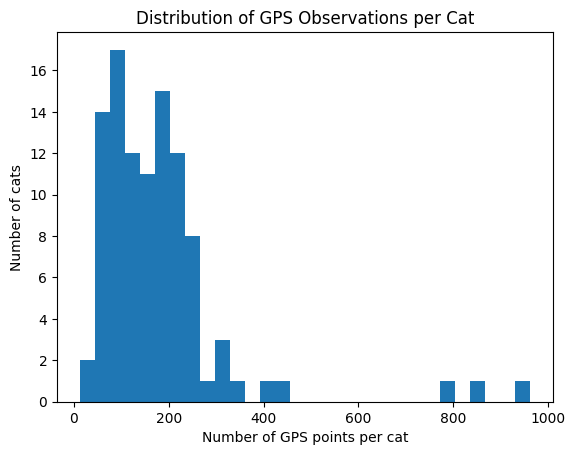

In [15]:
points_per_cat = cats_uk.groupby("tag_id").size()

plt.figure()
plt.hist(points_per_cat, bins=30)
plt.xlabel("Number of GPS points per cat")
plt.ylabel("Number of cats")
plt.title("Distribution of GPS Observations per Cat")
plt.show()

**The distribution reveals substantial heterogeneity in observation counts across cats.
Some individuals are tracked only sparsely, while others have hundreds of recorded locations.
This uneven observation density indicates that raw trajectory comparisons would conflate spatial behavior
with tracking frequency, motivating a more robust representation.
t**

#Section 4. Motivation for Aggregate Spatial Representation

Because individual cats are observed unevenly, directly comparing raw GPS trajectories would bias the analysis
toward heavily tracked individuals. To address this issue, we aggregate point-level observations into
individual-level spatial summaries that capture overall movement extent and dispersion while remaining robust
to uneven sampling.


#Section 5. Construction of Individual-Level Spatial Features

In [16]:
cats_q1 = cats_uk.dropna(
    subset=["timestamp", "location_lat", "location_long"]
).copy()

points_per_cat = cats_q1.groupby("tag_id").size()
valid_cats = points_per_cat[points_per_cat >= 50].index
cats_q1 = cats_q1[cats_q1["tag_id"].isin(valid_cats)]


####**Feature construction**

In [17]:
def spatial_features(df):
    lat = df["location_lat"]
    lon = df["location_long"]
    return pd.Series({
        "lat_range": lat.max() - lat.min(),
        "lon_range": lon.max() - lon.min(),
        "lat_std": lat.std(),
        "lon_std": lon.std(),
        "n_points": len(df)
    })

features_q1 = cats_q1.groupby("tag_id").apply(spatial_features)
features_q1.head()


/tmp/ipython-input-3865721967.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_q1 = cats_q1.groupby("tag_id").apply(spatial_features)


,lat_range,lon_range,lat_std,lon_std,n_points
tag_id,,,,,
Abba-Tag,0.003963,0.010782,0.000407,0.001146,83.0
Alfie-Tag,0.004066,0.012550,0.000870,0.001753,187.0
Amber-Tag,0.030289,0.040155,0.002057,0.002686,218.0
Ares,0.002487,0.003378,0.000353,0.000569,103.0
Athena,0.002319,0.003988,0.000247,0.000416,106.0


**These features summarize each cat’s spatial movement independently of time, capturing both overall movement
extent and dispersion. By collapsing point-level data into individual-level vectors, we create a representation
that directly aligns with the research question.**


#Section 6. Scaling and Clusting of Spatial Representations

###Method 1: K-Means Clustering (Primary)

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = features_q1.drop(columns=["n_points"])
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
features_q1["kmeans_cluster"] = kmeans.fit_predict(X_scaled)


K-means clustering was applied to the standardized spatial feature vectors to identify distinct spatial
movement styles. This method is appropriate because it groups individuals based on overall similarity in
spatial behavior rather than temporal ordering.

Multiple values of k were explored, with k=3 selected as a balance between interpretability and behavioral
distinction.

###Method 2: Hierarchical Clustering (Comparison)

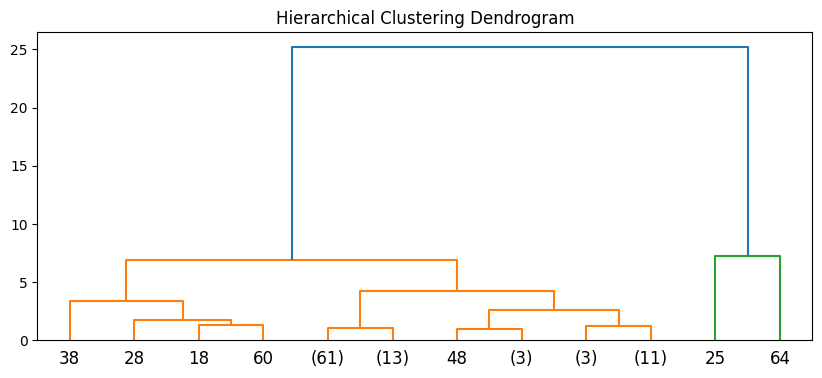

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(10,4))
dendrogram(Z, truncate_mode="lastp", p=12)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

features_q1["hier_cluster"] = fcluster(Z, 3, criterion="maxclust")

Hierarchical clustering was used as a complementary approach to assess the robustness of the clustering
structure. The consistency between hierarchical and k-means results increases confidence that the observed
groupings reflect meaningful spatial differences rather than artifacts of a single method.

#### Reason to use K-Means as a Primary and Hierachical as a comparison?

#Section 7. Interpretation of Distinct Spatial Movement Styles

In [20]:
features_q1.groupby("kmeans_cluster").mean()

,lat_range,lon_range,lat_std,lon_std,n_points,hier_cluster
kmeans_cluster,,,,,,
0,0.011401,0.013692,0.001056,0.001358,183.572917,1.0
1,0.434002,0.693840,0.026791,0.042788,261.000000,3.0
2,0.369648,0.315137,0.026679,0.017294,232.000000,2.0


The clusters correspond to qualitatively distinct spatial movement styles. One group exhibits highly localized
movement with limited spatial extent, while another covers substantially broader areas. A third group falls
between these extremes, suggesting intermediate spatial usage patterns.

#Section 8. Limitations & Transition to Q2

This analysis intentionally excludes temporal information, focusing solely on aggregate spatial behavior.
As a result, it cannot distinguish between cats that use space similarly but differ in how movement unfolds
over time. This limitation motivates Question 2, which incorporates temporal structure to examine roaming
patterns beyond aggregate spatial summaries.
